# IAPR: Project ‒  Coin Counter


**Group ID:** 12

**Author 1 (sciper):** Vray Alexandre (310104)   
**Author 2 (sciper):** Aellen Edgar (311574)  
**Author 3 (sciper):** Robrdet Alexis (371391)   

**Release date:** 26.04.2024  
**Due date:** 29.05.2024 (11:59 pm)

In [1]:
import cv2
import os

import numpy as np
import pandas as pd
import random
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt

from utils.display import plot_images

data_folder = 'data/train'

## Read data

In [2]:
def image_type(row):
    id = int(row['id'][5:])
    if 277 <= id <= 323 or 405 <= id <= 454:
        return 0
    elif 325 <= id <= 370 or 462 <= id <= 503:
        return 1
    else:
        return 2



data = pd.read_csv('data/train_labels.csv').sort_values(by='id')
data['type'] = data.apply(image_type, axis=1)

data

,id,5CHF,2CHF,1CHF,0.5CHF,0.2CHF,0.1CHF,0.05CHF,2EUR,1EUR,0.5EUR,0.2EUR,0.1EUR,0.05EUR,0.02EUR,0.01EUR,OOD,type
6,L1010277,1,0,0,0,0,0,0,1,0,1,2,0,0,0,0,0,0
10,L1010279,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0
0,L1010281,0,0,0,0,2,3,1,0,0,0,0,0,2,0,0,0,0
15,L1010283,0,0,0,1,0,0,0,1,0,2,1,0,1,0,0,0,0
8,L1010287,0,1,1,0,0,0,1,0,0,0,0,2,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,L1010515,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2
74,L1010517,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2
78,L1010521,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2
80,L1010523,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,2


In [3]:
def load_images_from_folder(folder):
    images = []
    for root, _, filenames in sorted(os.walk(folder)):
        for filename in sorted(filenames):
            img = cv2.imread(os.path.join(root, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
    return np.array(images)

# Replace 'path_to_your_folder' with the path to the folder containing your images
x = load_images_from_folder(data_folder)
y = data.loc[:,'5CHF':'OOD'].values
types = data['type'].values

random.seed(42)
shuffle = random.sample(range(len(x)), k=len(x))
x = [x[i] for i in shuffle]
y = y[shuffle]
types = types[shuffle]

x_train = x[:int(0.8*len(x))]
y_train = y[:int(0.8*len(y))]
types_train = types[:int(0.8*len(types))]

x_val = x[int(0.8*len(x)):]
y_val = y[int(0.8*len(y)):]
types_val = types[int(0.8*len(types)):]

labels = data.loc[:,'5CHF':'OOD'].columns

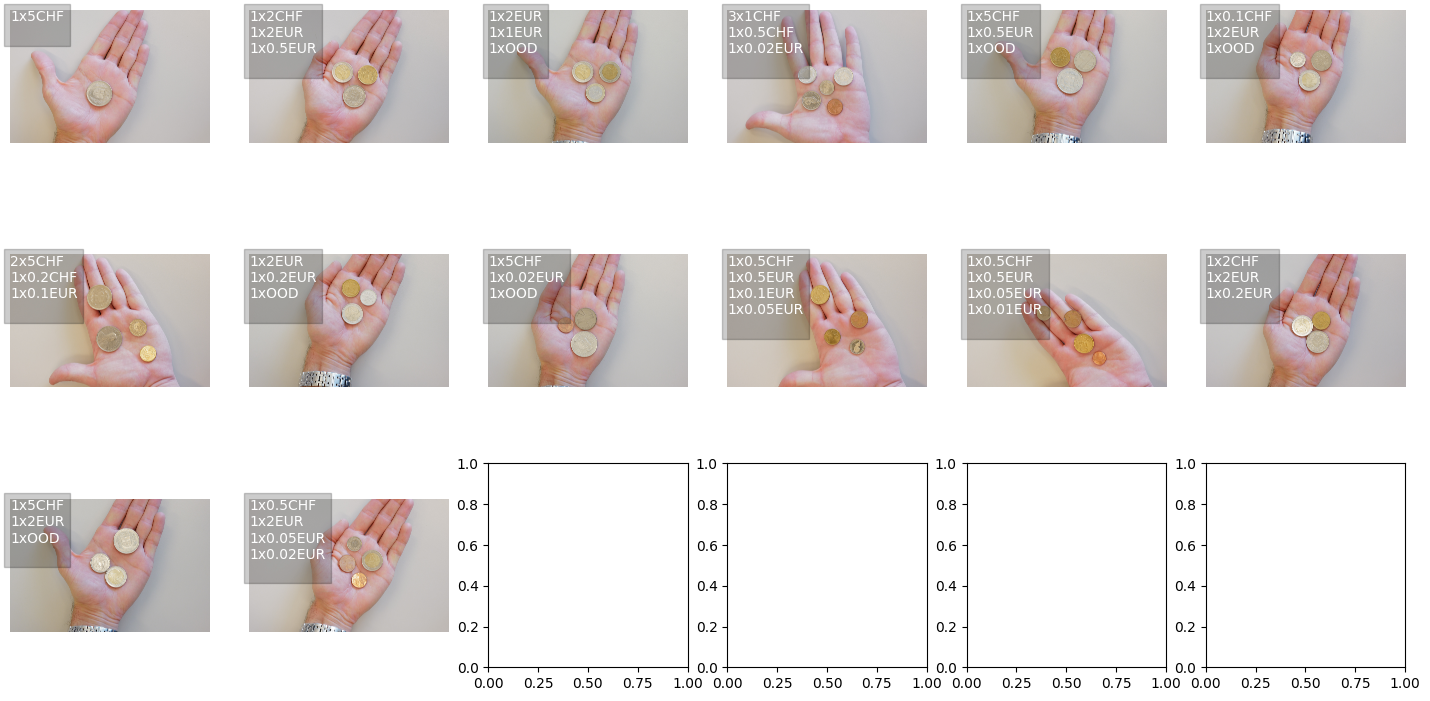

In [4]:
x_sample = [x_train[i] for i in range(len(x_train)) if types_train[i] == 2]
y_sample = y_train[types_train == 2]

plot_images(images=x_sample, coins=y_sample)

## 1. Localization

In [5]:
x_sample = [cv2.resize(x_sample[i], (600, 400)) for i in range(len(x_sample))]

In [6]:
# Mean_color = np.zeros((len(x_train),3))
# for i in range(len(x_train)):
#     Mean_color[i,:] = x_train[i].mean(axis=(0,1))

# np.shape(Mean_color)

In [7]:
# fig, axs = plt.subplots(1, 2, figsize=(6, 3))

# axs[0].scatter(Mean_color[:,0], Mean_color[:,1], c=types_train, cmap='viridis')

# sc = axs[1].scatter(Mean_color[:,0], Mean_color[:,1]/Mean_color[:,0], c=types_train, cmap='viridis')

# plt.colorbar(sc)

Image 0: Hand
Image 1: Hand
Image 2: Hand
Image 3: Hand
Image 4: Hand
Image 5: Hand
Image 6: Hand
Image 7: Hand
Image 8: Hand
Image 9: Hand
Image 10: Hand
Image 11: Hand
Image 12: Hand
Image 13: Hand


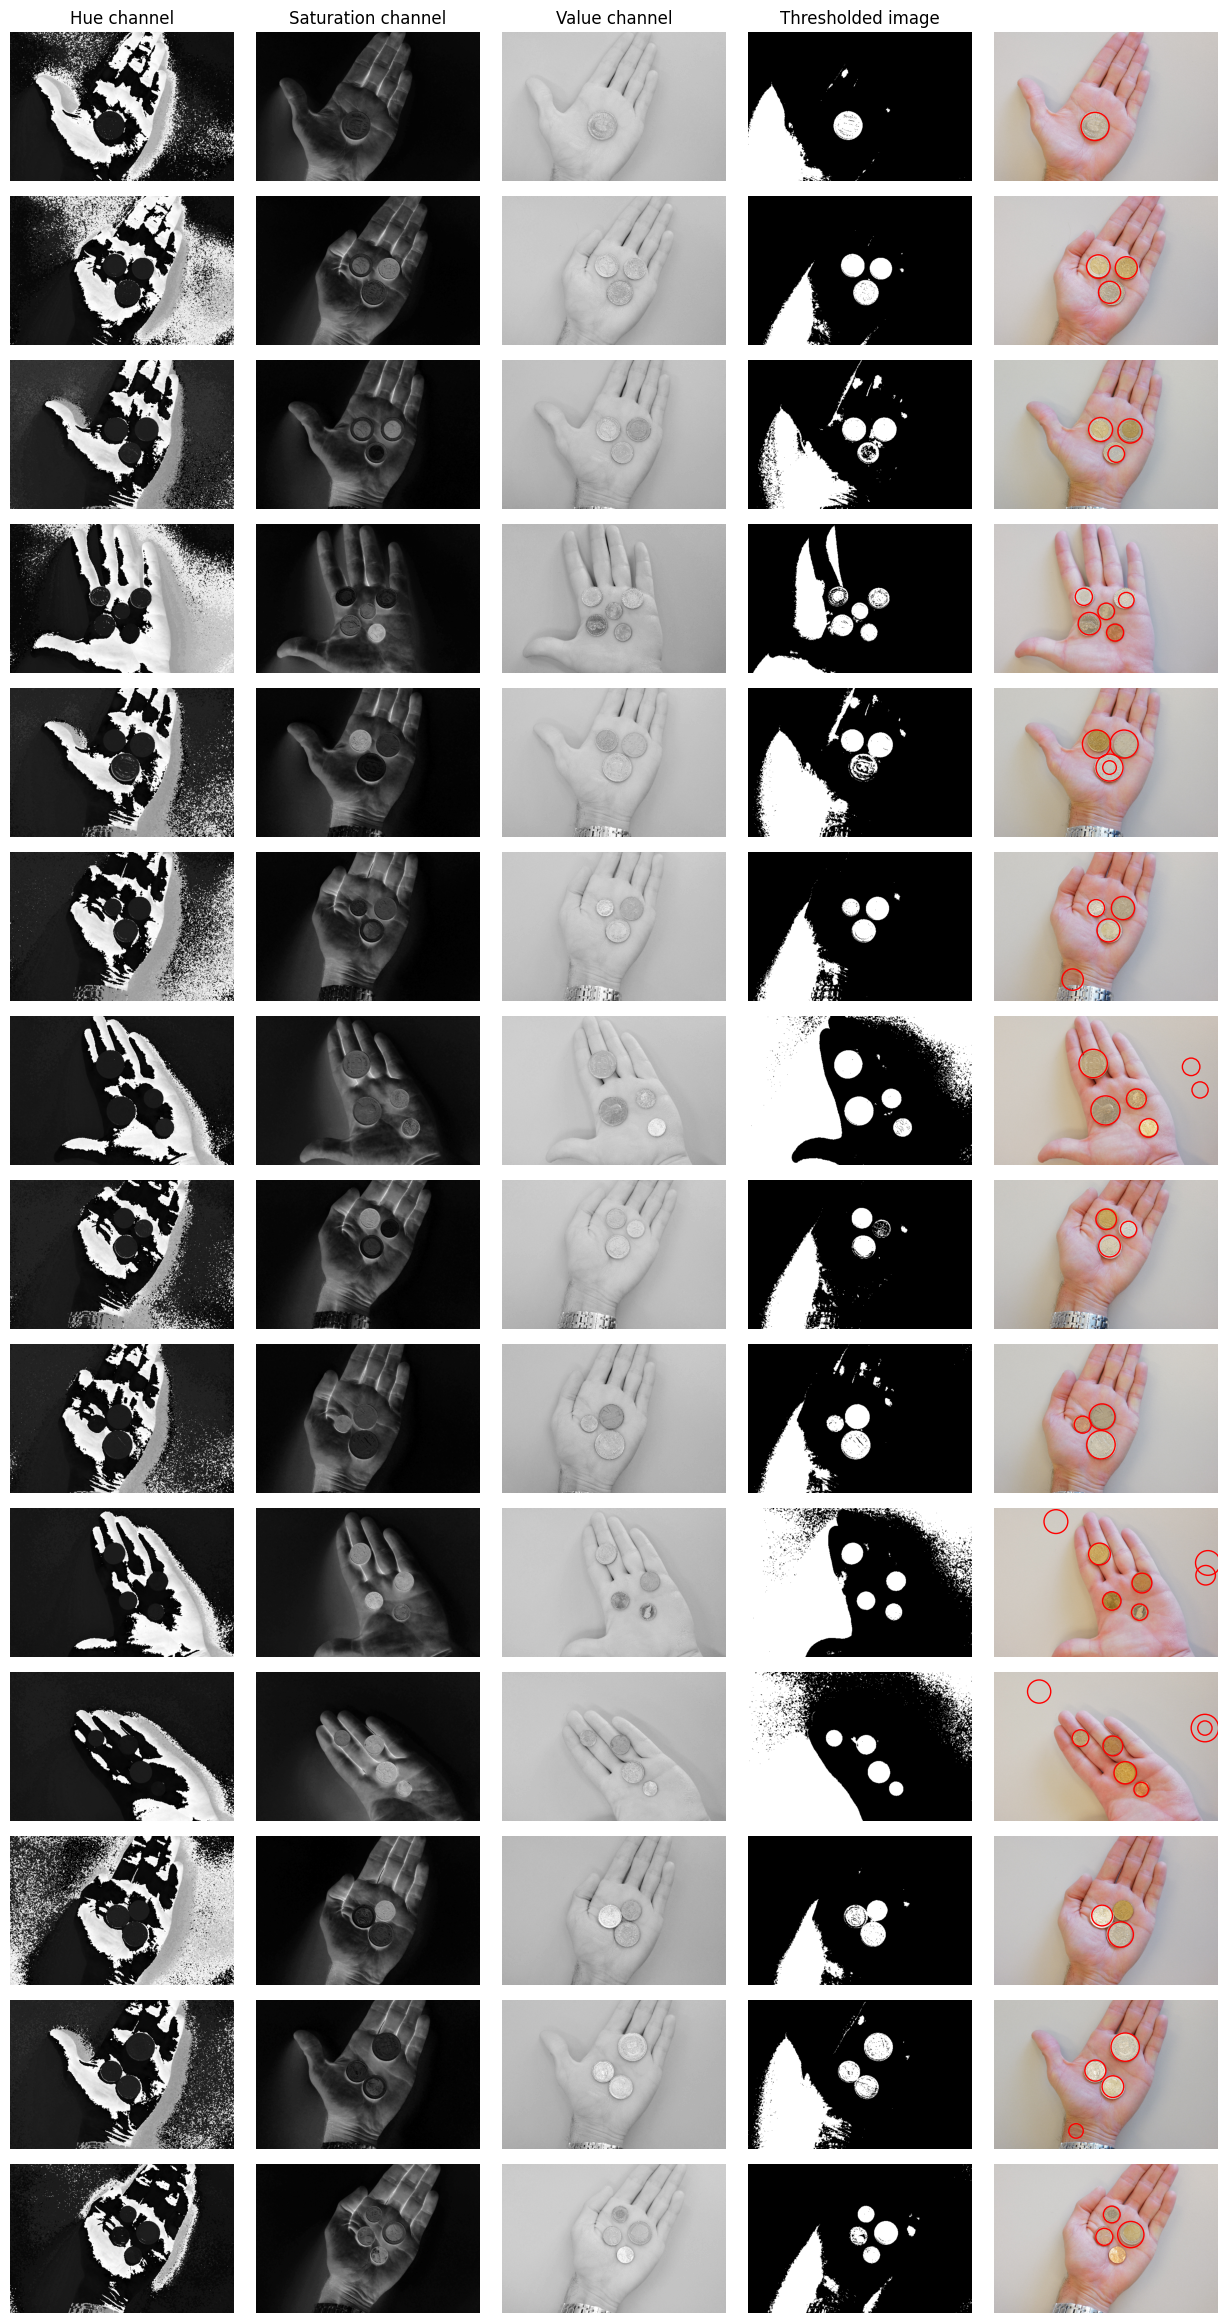

In [89]:
_, axs = plt.subplots(len(x_sample), 5, figsize=(15/6*5,5/3*len(x_sample)))

axs[0,0].set_title('Hue channel')
axs[0,1].set_title('Saturation channel')
axs[0,2].set_title('Value channel')
axs[0,3].set_title('Thresholded image')

for i in range(len(x_sample)):
    mean_color = x_sample[i].mean(axis=(0,1))
    gr_red_ratio = mean_color[1]/mean_color[0]

    red = x_sample[i][:,:,0].astype(np.float32)
    green = x_sample[i][:,:,1].astype(np.float32)
    blue = x_sample[i][:,:,2].astype(np.float32)

    hsv_img = cv2.cvtColor(x_sample[i], cv2.COLOR_RGB2HSV)
    hue = hsv_img[:,:,0].astype(np.float32)
    saturation = hsv_img[:,:,1].astype(np.float32)
    value = hsv_img[:,:,2].astype(np.float32)

    if gr_red_ratio>1: #55<=hue_th <=68:
        print(f'Image {i}: Noisy background')
        saturation_th = 90
        value_th = 230

        smh = (saturation-hue).clip(0,255).astype(np.uint8)
        # print(smh)

        # img_th = (saturation>saturation_th) & (hue<hue_th)
        # img_th = img_th.astype(np.uint8)*255

        circles = cv2.HoughCircles(smh,cv2.HOUGH_GRADIENT_ALT,1.5,20, param1=1,param2=0.49,minRadius=5,maxRadius=50)

    elif gr_red_ratio<0.94: #hue_th >= 79  and saturation_th < 65:
        print(f'Image {i}: Hand')
        saturation_th = 30
        value_th = 190

        rmg = (30-hue).clip(0,255)
        
        
        hand = (red>180)&(green<180)
        background = (saturation<15)

        rmg = (rmg>5) & (rmg<20) & ~background
        rmg = rmg.astype(np.uint8)
        circles = cv2.HoughCircles(rmg,cv2.HOUGH_GRADIENT_ALT,1.5,20, param1=1,param2=0.01,minRadius=5,maxRadius=50)
    else:
        print(f'Image {i}: Neutral background')
        # saturation_th = 50

        # struct_elmt = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
        # img_th = (saturation>saturation_th)
        # img_th = img_th.astype(np.uint8)*255

        circles = cv2.HoughCircles(saturation.astype(np.uint(8)),cv2.HOUGH_GRADIENT_ALT,1.5,20, param1=1,param2=0.5,minRadius=5,maxRadius=50)
        
        # img_th = cv2.morphologyEx(img_th, cv2.MORPH_DILATE, struct_elmt, iterations=8)
        # img_th = cv2.morphologyEx(img_th, cv2.MORPH_ERODE, struct_elmt, iterations=9)
        
        
    
   


    
    # contours, _ = cv2.findContours(img_th, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # circles = cv2.HoughCircles(img_th,cv2.HOUGH_GRADIENT,1,20, param1=20,param2=45,minRadius=10,maxRadius=50)
    # circles = cv2.HoughCircles(img_th, cv2.HOUGH_GRADIENT, 2, 400/4, 10, 1, minRadius=10, maxRadius=1000 )
    
 
    

    axs[i,0].imshow(hue, cmap='gray')
    axs[i,0].axis('off')

    axs[i,1].imshow(saturation, cmap='gray')
    axs[i,1].axis('off')

    axs[i,2].imshow(value, cmap='gray')
    axs[i,2].axis('off')

    axs[i,3].imshow(rmg, cmap='gray')
    axs[i,3].axis('off')   

    axs[i,4].imshow(x_sample[i])
    axs[i,4].axis('off')

    # if contours is not None:
    #     for contours in contours:
            
    #         (x, y), radius = cv2.minEnclosingCircle(contours)
    #         center = (int(x), int(y))
    #         area = np.pi*radius**2
    #         # if area < 1000 or area > 15000:
    #         #     continue
    #         circle = plt.Circle(center, radius, color='r', fill=False)  # Create a circle object
    #         axs[i,3].add_artist(circle)  # Add the circle to the plot

    if circles is not None:
        for circle in circles[0]:
            if circle is not None:
                x, y, radius = circle
                center = (int(x), int(y))
                area = np.pi*radius**2
                if area < 1000 or area > 15000:
                    continue
                circle = plt.Circle(center, radius, color='r', fill=False)  # Create a circle object
                axs[i,4].add_artist(circle)  # Add the circle to the plot


plt.tight_layout()
    


In [9]:
# hsv_img = cv2.cvtColor(x_test[0], cv2.COLOR_RGB2HSV)
# hue = hsv_img[:,:,1]

# # Fit a Gaussian mixture model to the histogram
# gmm = GaussianMixture(n_components=2)
# gmm.fit(hue.reshape(-1, 1))

# # Extract the means of the Gaussian components
# means = gmm.means_.flatten()

# # Use the mean between the two Gaussian components as the threshold
# threshold = np.mean(means)

# print('Threshold:', threshold)

## 2. Feature extraction

## 3. Classification